In [1]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from collections import deque

# Added library
import heapq

random.seed(42)

# SYSTEM PARAMETERS

You are free to change the value of these variables for testing, but do not add extra variables here. This entire block will be replaced when marking.

In [2]:
# DO NOT ADD OTHER VARIABLES HERE

# General settings
seed = 42
image_file = "sample_map.png"

# Task 1 - Occupancy map
unsafe_kernel_size = 7
unsafe_iterations = 3

# Task 3 - BFS
bfs_n = 10
bfs_start_node = 0
bfs_end_node = 99

# Task 4 - PRM and Dijkstra
prm_total_nodes_count = 30
prm_connection_radius = 200
prm_start_location = (50,50)
prm_goal_location = (450,450)

# Task 5 - RRT
rrt_max_nodes_count = 500
rrt_step_size = 40
rrt_max_connection_length = 200
rrt_start_location = (50,50)
rrt_goal_location = (450,450)

# DO NOT ADD OTHER VARIABLES HERE

# Task 1 - OCCUPANCY MAP (5 marks total)

Occupancy map loaded with shape: (500, 500, 3)


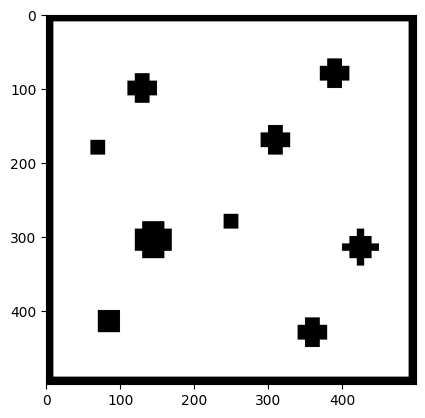

In [3]:
# Task 1.1 (1 mark): Display the occupancy map
image = cv2.imread('sample_map.png')

# Check if image loaded properly
if image is None:
    print("Error: The image wasn't found or failed to load.")
else:
    print(f"Occupancy map loaded with shape: {image.shape}")

plt.imshow(image)
plt.show()


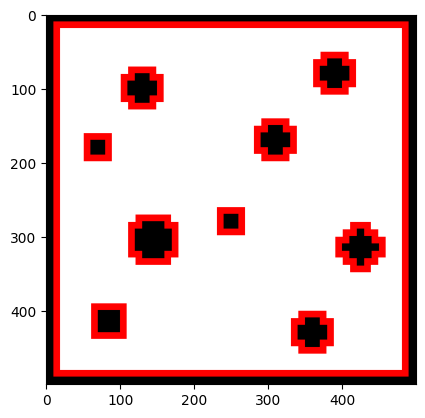

In [4]:
# Task 1.2 (4 Marks): Process occupancy map add and display configuration space

grayscaleImg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Make a binary mask: obstacles = 1, free = 0
obstacleMask = (grayscaleImg == 0).astype(np.uint8)

kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8) # to generate unsafe area

# Dilate obstacle areas for buffer 
dilatedMask = cv2.dilate(obstacleMask, kernel, iterations=unsafe_iterations)

# Remake 3-channel RGB 
image = cv2.cvtColor(grayscaleImg, cv2.COLOR_GRAY2RGB)

# Make unsafe buffer zone red
buffer_zone = (dilatedMask == 1) & (obstacleMask == 0)
image[buffer_zone] = [255, 0, 0] 



# Display resulting image
plt.imshow(image)
plt.show()

# Task 2 - Graph Class (0 marks total)

NOTE: This is slightly different to the graph in lab 07. x,y variables have been added to the node object.

In [5]:
# Task 2.1 (0 marks):  Complete the graph class

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        # id -> Node
        self.nodes = {}  
        # id -> dict of neighbor_id -> weight
        self.edges = {}  

    def add_node(self, node_id, x, y):
        # Add new if it doesn't exist
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        # Add edge(no direction)
        if node_id1 in self.nodes and node_id2 in self.nodes:
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight

    def remove_edge(self, node_id1, node_id2):
        # Remove edge if exists
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            del self.edges[node_id1][node_id2]
        if node_id2 in self.edges and node_id1 in self.edges[node_id2]:
            del self.edges[node_id2][node_id1]
    
    def get_nodes(self):
        # Return list of node IDs
        return list(self.nodes.keys())
    
    def get_edge_weight(self, node_id1, node_id2):
        # Return weight if edge exists
        return self.edges.get(node_id1, {}).get(node_id2, None)


# Task 3 - BFS (10 marks total)

In [6]:
# This is a useful function that you may choose to implement and use 
# It looks through the image to see if the path is clear between one coordinate to the next
# Returns True or False 

def bresenhamLine(x0, y0, x1, y1):
    # Bresenham's line algo to get all points between (x0,y0) and (x1,y1)
    points = []
    dx = abs(x1 - x0)
    dy = -abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx + dy  # error value

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        err2 = 2 * err
        
        if err2 >= dy:
            err += dy
            x0 += sx
            
        if err2 <= dx:
            err += dx
            y0 += sy
            
    return points


def path_clear(image, x1, y1, x2, y2):
    points = bresenhamLine(x1, y1, x2, y2)
    for (x, y) in points:
        if x < 0 or y < 0 or y >= image.shape[0] or x >= image.shape[1]:
            return False
        
        pixel = image[y, x]
        
        # For grayscale:
        if len(image.shape) == 2:
            if pixel == 0:  # obstacle found
                return False
        
        # For color (RGB)
        elif len(image.shape) == 3:
            # Check black obstacle
            if (pixel == [0, 0, 0]).all():
                return False
            # Check buffer zone
            if (pixel == [255, 0, 0]).all():
                return False
        
        else:
            return False

    return True



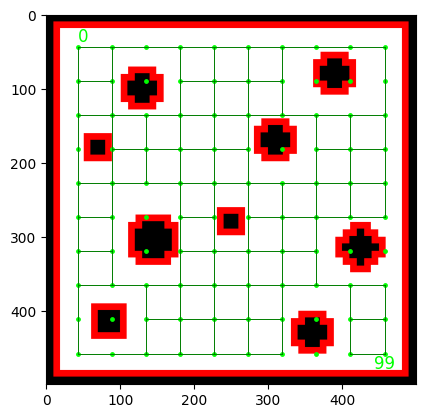

In [7]:
# Task 3.1 (5 marks): Generate a grid of nodes and connect the edges

# bfsImg = cv2.imread('sample_map.png')
bfsImg = image.copy()
bfsGraph = Graph()

height, width = bfsImg.shape[:2]

margin = seed  ############################################### ASK ABOUT THIS ################################################# 
# Generate grid points, margin added for equal spacing throught
xCoords = np.linspace(margin+1, width - margin, bfs_n).astype(int)
yCoords = np.linspace(margin+1, height - margin, bfs_n).astype(int)

# Add nodes to graph
nodeIDMap = {}  
nodeID = 0

# Add nodes with x,y coordinates and store their ID mapping
for row, y in enumerate(yCoords):
    for col, x in enumerate(xCoords):
        bfsGraph.add_node(nodeID, x, y)
        nodeIDMap[(row, col)] = nodeID
        nodeID += 1


# Connect neighbours if path_clear
for row in range(bfs_n):
    for col in range(bfs_n):
        currentID = nodeIDMap[(row, col)]
        x1, y1 = bfsGraph.nodes[currentID].get_point()

        # Right neighbour
        if col + 1 < bfs_n:
            rightID = nodeIDMap[(row, col + 1)]
            x2, y2 = bfsGraph.nodes[rightID].get_point()
            if path_clear(bfsImg, x1, y1, x2, y2):
                bfsGraph.add_edge(currentID, rightID, 1)

        # Down neighbour
        if row + 1 < bfs_n:
            downID = nodeIDMap[(row + 1, col)]
            x2, y2 = bfsGraph.nodes[downID].get_point()
            if path_clear(bfsImg, x1, y1, x2, y2):
                bfsGraph.add_edge(currentID, downID, 1)

# Display result before overlay
plt.imshow(bfsImg)


# I CHANGED THE OVERLAY GRAPHIC PROPERITES TO MEET THE IMAGE IN THE ASSIGNMENT. THE CODE THAT MATCHES THE SPEC VALUES IS STILL COMMENTED
for nodeID, neighbours in bfsGraph.edges.items():
    x1, y1 = bfsGraph.nodes[nodeID].get_point()
    for neighbor_id in neighbours.keys():
        x2, y2 = bfsGraph.nodes[neighbor_id].get_point()
        # plt.plot([x1, x2], [y1, y2], color=(0, 125/255, 0), linewidth=1)  # dark green lines as per assignment spec, color is 0->1
        plt.plot([x1, x2], [y1, y2], color=(0, 125/255, 0), linewidth=0.6)

# Draw nodes as light green circles
for nodeID, node in bfsGraph.nodes.items():
    x, y = node.get_point()
    # plt.scatter(x, y, s=30, color=(0, 1, 0))  # light green, radius 3 (size=30 approx)
    plt.scatter(x, y, s=6, color=(0, 1, 0))

# Label start and goal in bright green
plt.text(bfsGraph.nodes[0].x, bfsGraph.nodes[0].y - 7, '0', color=(0,1,0), fontsize=12)
goalID = bfs_n * bfs_n - 1
plt.text(bfsGraph.nodes[goalID].x - 15, bfsGraph.nodes[goalID].y + 20, str(goalID), color=(0,1,0), fontsize=12)


plt.show()


In [8]:
# Task 3.2 (5 marks): Implement BFS
# Returns an array of nodes in order of which nodes are visited next.

def bfs(graph, start_node_id, end_node_id):
    visited = set()
    queue = deque([start_node_id])
    predecessors = {start_node_id: None}

    # Using queues for BFS
    while queue:
        current = queue.popleft()
        if current == end_node_id:
            path = []
            while current is not None:
                path.append(current)
                current = predecessors[current]
            return path[::-1]

        visited.add(current)

        # Calculate row and col from node ID
        row = current // bfs_n
        col = current % bfs_n

        neighboursToVisit = []

        # Add down neighbour if exists
        if row + 1 < bfs_n:
            downID = (row + 1) * bfs_n + col
            if downID in graph.edges.get(current, {}) and downID not in visited:
                neighboursToVisit.append(downID)

        # Add right neighbour if exists
        if col + 1 < bfs_n:
            rightID = row * bfs_n + (col + 1)
            if rightID in graph.edges.get(current, {}) and rightID not in visited:
                neighboursToVisit.append(rightID)

        # Enqueue neighbours in down to right order
        for neighbour in neighboursToVisit:
            if neighbour not in visited and neighbour not in queue:
                predecessors[neighbour] = current
                queue.append(neighbour)

    return []

Path: [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]


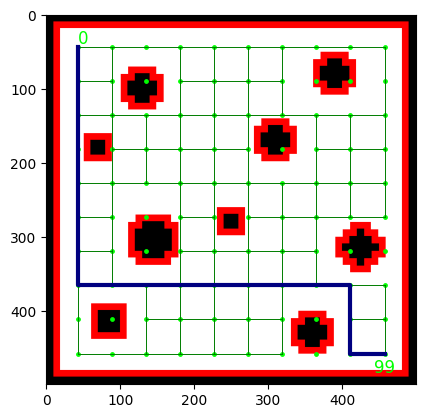

In [9]:
# Task 3.2: Implement BFS continued

# Run BFS and display the output
path = bfs(bfsGraph,bfs_start_node,bfs_end_node)

# Display the resulting image
print(f"Path: {path}")
plt.imshow(bfsImg)

for node_id, neighbours in bfsGraph.edges.items():
    x1, y1 = bfsGraph.nodes[node_id].get_point()
    for neighbor_id in neighbours.keys():
        x2, y2 = bfsGraph.nodes[neighbor_id].get_point()
        # plt.plot([x1, x2], [y1, y2], color=(0, 125/255, 0), linewidth=1) # As per spec values 
        plt.plot([x1, x2], [y1, y2], color=(0, 125/255, 0), linewidth=0.6) 

for node_id, node in bfsGraph.nodes.items():
    x, y = node.get_point()
    # plt.scatter(x, y, s=30, color=(0, 1, 0)) # As per spec values
    plt.scatter(x, y, s=6, color=(0, 1, 0))

# Plot the BFS path blue
if len(path) > 1:
    path_points_x = [bfsGraph.nodes[node_id].x for node_id in path]
    path_points_y = [bfsGraph.nodes[node_id].y for node_id in path]
    plt.plot(path_points_x, path_points_y, color=(0,0,0.5), linewidth=3, label='BFS Path')

# Label start and goal
plt.text(bfsGraph.nodes[bfs_start_node].x , bfsGraph.nodes[bfs_start_node].y - 5, '0', color=(0,1,0), fontsize=12)
plt.text(bfsGraph.nodes[bfs_end_node].x - 15, bfsGraph.nodes[bfs_end_node].y + 25, str(bfs_end_node), color=(0,1,0), fontsize=12)


plt.show()

# Task 4 -  PRM and Dijkstra Algorithm (6 marks total)

In [10]:
# This is a useful function that you may choose to implement and use 
# It finds and returns the closest nodes that are within the range

def check_line_collision(image, pt1, pt2):
    # Check if the line between pt1 and pt2 crosses red or black pixels
    # Generate all pixel coordinates on line using Bresenham's algo
    mask = np.zeros(image.shape[:2], dtype = np.uint8)
    cv2.line(mask, pt1, pt2, 1, 1)
    ys, xs = np.where(mask == 1)

    for y, x in zip(ys, xs):
        if x < 0 or x >= image.shape[1] or y < 0 or y >= image.shape[0]:
            continue  # Skip out of bounds conditions

        r, g, b = image[y, x]
        if (r == 0 and g == 0 and b == 0) or (r > 200 and g < 100 and b < 100):
            return True

    return False  # Line valid


def find_closest_nodes(image, graph, targetX, targetY, range):
    # Finds nodes within range of given target (x, y), not blocked by obstacles
    distances = []

    for node_id, node in graph.nodes.items():
        nx, ny = node.x, node.y  # Access attributes of the Node object
        dist = math.hypot(targetX - nx, targetY - ny)
        if dist <= range:
            if not check_line_collision(image, (targetX, targetY), (nx, ny)):
                distances.append((dist, node_id))

    distances.sort(key=lambda x: x[0])
    return distances




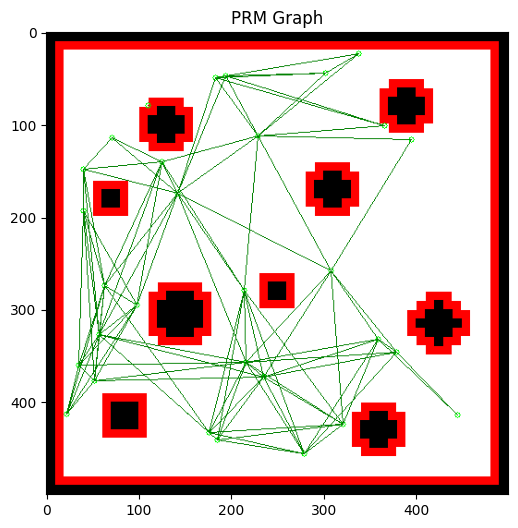

In [11]:
# Task 4.1 (3 marks): PRM
# NOTE: The iteration only increases when a valid node is placed on the map. If the node is invalid, the program should continue without incrementing the node count. 
prmImg = image.copy()
prmGraph = Graph()
random.seed(seed)

i = 0
node_id = 0
margin = seed 

while i < prm_total_nodes_count:
    y = random.randint(0, prmImg.shape[1] - 1)
    x = random.randint(0, prmImg.shape[0] - 1)

    r, g, b = prmImg[y, x]

    # Skip red or black 
    if (r == 0 and g == 0 and b == 0) or (r > 200 and g < 100 and b < 100):
        continue

    prmGraph.add_node(node_id, x, y)
    i += 1

    # Connect to nearby nodes
    connections = find_closest_nodes(prmImg, prmGraph, x, y, prm_connection_radius)
    for dist, neighbor_id in connections:
        prmGraph.add_edge(node_id, neighbor_id, dist)

    node_id += 1

# Display the resulting image
for nid, node in prmGraph.nodes.items():
    x, y = node.get_point()
    cv2.circle(prmImg, (x, y), 3, (0, 255, 0), 1)

# Draw edges
for n1 in prmGraph.edges:
    for n2, _ in prmGraph.edges[n1].items():
        pt1 = prmGraph.nodes[n1].get_point()
        pt2 = prmGraph.nodes[n2].get_point()
        cv2.line(prmImg, pt1, pt2, (0, 255/2, 0), 1)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(prmImg)
plt.title("PRM Graph")
plt.show()


In [12]:
# Task 4.2 (3 marks): Djistraks
def dijkstra(graph, startID, endID):
    # Dijkstra’s algo using a priority queue from heapq lib
    queue = [(0, startID, [startID])]
    visited = set()

    while queue:
        cost, current, path = heapq.heappop(queue)

        if current == endID:
            return (path, cost)

        if current in visited:
            continue
        visited.add(current)

        for neighbor, weight in graph.edges.get(current, {}).items():
            if neighbor not in visited:
                heapq.heappush(queue, (cost + weight, neighbor, path + [neighbor]))

    return ([], float('inf'))  # No path found

Path: [-1, 14, 7, 9, -2], Cost: 579.3306319068793


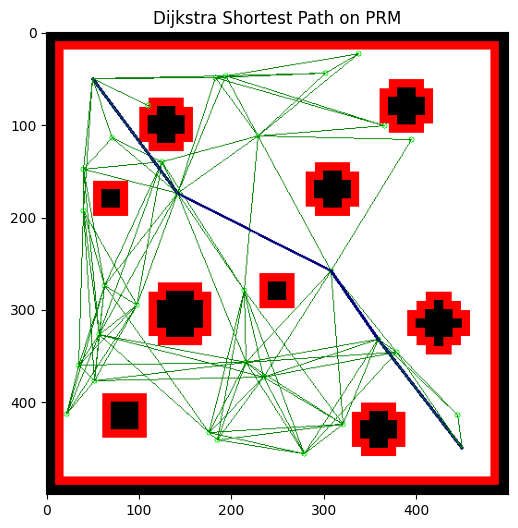

In [13]:
# Task 4.2: Djistraks continued

# Add start(-1) and goal(-2) node
prmGraph.add_node(-1, prm_start_location[0], prm_start_location[1])
prmGraph.add_node(-2, prm_goal_location[0], prm_goal_location[1])

# Connect them to nearby nodes in graph
startConns = find_closest_nodes(prmImg, prmGraph, *prm_start_location, prm_connection_radius)
goalConns  = find_closest_nodes(prmImg, prmGraph, *prm_goal_location, prm_connection_radius)

for dist, neighbor_id in startConns:
    prmGraph.add_edge(-1, neighbor_id, dist)

for dist, neighbor_id in goalConns:
    prmGraph.add_edge(-2, neighbor_id, dist)

# Run Dijkstra's algo
path, cost = dijkstra(prmGraph, -1, -2)

# Visualise Dijkstra path
for i in range(len(path) - 1):
    pt1 = prmGraph.nodes[path[i]].get_point()
    pt2 = prmGraph.nodes[path[i + 1]].get_point()
    cv2.line(prmImg, pt1, pt2, (0, 0, 125), 2)  # Blue

# Visualise all start & goal edges
for neighbor_id in prmGraph.edges[-1]:
    pt1 = prmGraph.nodes[-1].get_point()
    pt2 = prmGraph.nodes[neighbor_id].get_point()
    cv2.line(prmImg, pt1, pt2, (0, 125, 0), 1)  # Green

for neighbor_id in prmGraph.edges[-2]:
    pt1 = prmGraph.nodes[-2].get_point()
    pt2 = prmGraph.nodes[neighbor_id].get_point()
    cv2.line(prmImg, pt1, pt2, (0, 125, 0), 1)  # Green


# Show result
print(f"Path: {path}, Cost: {cost}")
plt.figure(figsize=(6, 6))
plt.imshow(prmImg)
plt.title("Dijkstra Shortest Path on PRM")
plt.show()


# Task 5 - Rapidly-exploring random trees (RRT) (4 marks total)

In [14]:
# This is a useful function which you may choose to impliment and use 
# Given a random point it extends the tree by either the step distance or the cartesian distance

def calculate_new_tree_point(xClosest, yClosest, x, y, step):
    dx = x - xClosest
    dy = y - yClosest
    distance = math.hypot(dx, dy)
    
    if distance == 0:
        return xClosest, yClosest, 0
        
    scale = min(step, distance) / distance
    newX = int(xClosest + dx * scale)
    newY = int(yClosest + dy * scale)
    
    return newX, newY, scale * distance

def find_closest_node_rrt(graph, x, y):
    minDist = float('inf')
    closestID = None
    for node_id, node in graph.nodes.items():
        dist = math.hypot(x - node.x, y - node.y)
        if dist < minDist:
            minDist = dist
            closestID = node_id
    return closestID, minDist


def find_closest_nodes(image, graph, targetX, targetY, radius):
    distances = []
    for node_id, node in graph.nodes.items():
        nx, ny = node.x, node.y
        dist = math.hypot(targetX - nx, targetY - ny)
        if dist <= radius:
            if not check_line_collision(image, (targetX, targetY), (nx, ny)):
                distances.append((dist, node_id))
    distances.sort(key=lambda x: x[0])
    return distances


RRT* solution found after 4 nodes with a total cost of 571.35


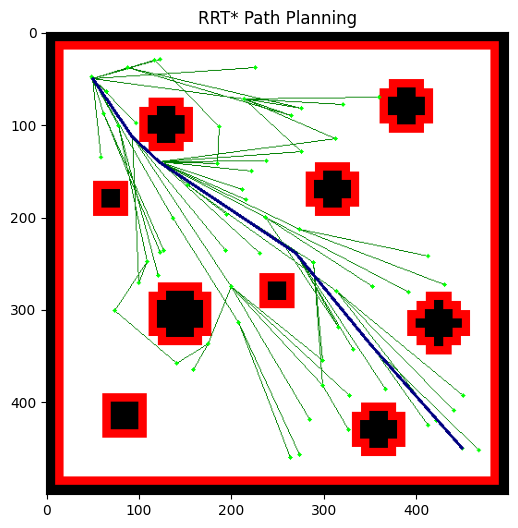

In [15]:
# RRT* algo
rrtImage = image.copy()
rrtGraph = Graph()
random.seed(seed)

startX, startY = rrt_start_location
goalX, goalY = rrt_goal_location
rrtGraph.add_node(-1, startX, startY)

cost = {-1: 0}
i = 0
node_id = 0
goalReached = False
goal_node_id = -2

while i < rrt_max_nodes_count:
    # GOAL BIAS SAMPLING
    if random.random() < 0.1:
        x, y = goalX, goalY
    else:
        y = random.randint(0, rrtImage.shape[1] - 1)
        x = random.randint(0, rrtImage.shape[0] - 1)

    r, g, b = rrtImage[y, x]
    if (r == 0 and g == 0 and b == 0) or (r > 200 and g < 100 and b < 100):
        continue

    closestID, _ = find_closest_node_rrt(rrtGraph, x, y)
    xClosest, yClosest = rrtGraph.nodes[closestID].get_point()

    newX, newY, step_dist = calculate_new_tree_point(xClosest, yClosest, x, y, rrt_step_size)
    if not (0 <= newX < rrtImage.shape[1] and 0 <= newY < rrtImage.shape[0]):
        continue

    Rnew, Gnew, Bnew = rrtImage[newY, newX]
    if (Rnew == 0 and Gnew == 0 and Bnew == 0) or (Rnew > 200 and Gnew < 100 and Bnew < 100):
        continue

    if check_line_collision(rrtImage, (xClosest, yClosest), (newX, newY)):
        continue

    # Get nearby nodes
    neighbours = find_closest_nodes(rrtImage, rrtGraph, newX, newY, rrt_max_connection_length)

    # Choose best parent
    minCost = float('inf')
    bestParent = None
    for dist, nid in neighbours:
        if nid in cost:
            parentX, parentY = rrtGraph.nodes[nid].get_point()
            if not check_line_collision(rrtImage, (parentX, parentY), (newX, newY)):
                c = cost[nid] + dist
                if c < minCost:
                    minCost = c
                    bestParent = nid

    if bestParent is not None:
        rrtGraph.add_node(node_id, newX, newY)
        rrtGraph.add_edge(bestParent, node_id, ...)
        node_id += 1  # Increment if node added
        i += 1
    else:
        continue

    # Add node
    if bestParent is not None:
        rrtGraph.add_node(node_id, newX, newY)
        rrtGraph.add_edge(bestParent, node_id, math.hypot(rrtGraph.nodes[bestParent].x - newX, rrtGraph.nodes[bestParent].y - newY))
        cost[node_id] = minCost
        i += 1
    else:
        continue  # Don't add node if no valid parent

    # Rewiring
    for dist, nid in neighbours:
        if nid == bestParent or nid not in cost:
            continue
        newCost = cost[node_id] + dist
        
        if newCost < cost[nid]:
            x_old, y_old = rrtGraph.nodes[nid].get_point()
            if not check_line_collision(rrtImage, (newX, newY), (x_old, y_old)):
                # Remove any existing edge to a parent
                old_parents = list(rrtGraph.edges[nid].keys())
                
                for parent in old_parents:
                    rrtGraph.remove_edge(nid, parent)
                    
                rrtGraph.add_edge(node_id, nid, dist)
                cost[nid] = newCost

    # Goal connection
    if math.hypot(newX - goalX, newY - goalY) <= rrt_max_connection_length:
        if not check_line_collision(rrtImage, (newX, newY), (goalX, goalY)):
            if not goalReached:
                rrtGraph.add_node(goal_node_id, goalX, goalY)
                rrtGraph.add_edge(node_id, goal_node_id, math.hypot(newX - goalX, newY - goalY))
                cost[goal_node_id] = cost[node_id] + math.hypot(newX - goalX, newY - goalY)
                goalReached = True

    if goalReached and i >= 150: # Early exit at 150
        break

    node_id += 1




# backtrack path from goal to start
def reconstructRRTpath(graph, startID, goalID):
    parent = {}
    visited = set()
    stack = [startID]

    while stack:
        current = stack.pop()
        visited.add(current)
        
        for neighbor, _ in graph.edges.get(current, {}).items():
            if neighbor not in visited:
                parent[neighbor] = current
                stack.append(neighbor)
                if neighbor == goalID:
                    path = [goalID]
                    while path[-1] != startID:
                        path.append(parent[path[-1]])
                    return path[::-1]
                    
    return []

# Draw RRT* tree
for n1 in rrtGraph.edges:
    for n2 in rrtGraph.edges[n1]:
        pt1 = rrtGraph.nodes[n1].get_point()
        pt2 = rrtGraph.nodes[n2].get_point()
        cv2.line(rrtImage, pt1, pt2, (0, 255/2, 0), 1)

# Draw nodes
for node in rrtGraph.nodes.values():
    x, y = node.get_point()
    cv2.circle(rrtImage, (x, y), 2, (0, 255, 0), -1)



# Draw final path
if goalReached:
    path = reconstructRRTpath(rrtGraph, -1, -2)
    for i in range(len(path) - 1):
        pt1 = rrtGraph.nodes[path[i]].get_point()
        pt2 = rrtGraph.nodes[path[i + 1]].get_point()
        cv2.line(rrtImage, pt1, pt2, (0, 0, 255/2), 2)  # Blue

# Show result
print(f"RRT* solution found after {i} nodes with a total cost of {cost[-2]:.2f}")
plt.figure(figsize=(6, 6))
plt.imshow(rrtImage)
plt.title("RRT* Path Planning")
plt.show()

